In [14]:
import os
import json
import string
import collections
import time
from tensorflow.keras.applications.inception_v3 import InceptionV3

def Process_Descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)           

def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(str(key) + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

PATH=os.path.abspath('/Users/danianmercado/Documents/machine_learning')
annotation_t=PATH+'/data/annotations/train.json'
annotation_v=PATH+'/data/annotations/val.json'
with open(annotation_t, 'r') as f:
    annotations_t = json.load(f)
    
with open(annotation_v, 'r') as f:
    annotations_v = json.load(f)
train_img= []
val_img= []
descriptions= collections.OrderedDict()
train_descriptions=collections.OrderedDict()
val_descriptions=collections.OrderedDict()

for annot in annotations_t['annotations']:
    caption = annot['caption']
    image_id = annot['image_id']
    filename = ""
    for img in annotations_t['images']:
        if (img['id'] == image_id):
            filename = img['file_name']
            break
    full_image_path = PATH + '/data/train/'+filename
    image_id_f = filename.split('.')[0]
    if caption != 'Quality issues are too severe to recognize visual content.':
        if image_id_f not in descriptions.keys():
            descriptions[image_id_f] = list()
        if image_id_f not in train_descriptions.keys():
            train_descriptions[image_id_f] = list()
        descriptions[image_id_f].append(caption)
        train_descriptions[image_id_f].append(caption)
        train_img.append(full_image_path)
    
for annot in annotations_v['annotations']:
    caption = annot['caption']
    image_id = annot['image_id']
    filename = ""
    for img in annotations_v['images']:
        if (img['id'] == image_id):
            filename = img['file_name']
            break
    full_image_path = PATH + '/data/val/'+filename
    image_id_f = filename.split('.')[0]
    if image_id_f not in descriptions.keys():
        descriptions[image_id_f] = list()
    if image_id_f not in val_descriptions.keys():
        val_descriptions[image_id_f] = list()
    descriptions[image_id_f].append(caption)
    val_descriptions[image_id_f].append(caption)
    val_img.append(full_image_path)

Process_Descriptions(descriptions)

save_descriptions(descriptions, 'descriptions.txt')

lines = list()
for key in train_descriptions.keys():
    lines.append(key)
data = '\n'.join(lines)
file = open('training_images_names', 'w')
file.write(data)
file.close()

lines = list()
for key in val_descriptions.keys():
    lines.append(key)
data = '\n'.join(lines)
file = open('val_images_names', 'w')
file.write(data)
file.close()

trainImagesPath='/Users/danianmercado/Documents/machine_learning/data/train/'

train_img_set = set(train_img)
val_img_set = set(val_img)

In [15]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

# extract features from each photo in the directory
def extract_features():
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    f = open('training_images_names', 'r')
    for name in f:
        name = name.strip()
        filename = os.path.abspath('.') + '/data/train/' + name+'.jpg'
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name
        features[image_id] = feature
        print('>%s' % name)
    f.close()
    f = open('val_images_names', 'r')
    for name in f:
        name = name.strip()
        filename = os.path.abspath('.') + '/data/val/' + name + '.jpg'
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name

        features[image_id] = feature
        print('>%s' % name)
    f.close()
    return features

# extract features from all images
features = extract_features()
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Add
from keras.callbacks import ModelCheckpoint
import keras
import numpy as np

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(1000,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = Add()([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	model.summary()
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [[in_img, in_seq], out_word]

# data generator, intended to be used in a call to model.fit_generator()
def data_generator1(descriptions, photos, tokenizer, max_length, vocab_size, photos_per_batch):            
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            if key in photos.keys():
                photo = photos[key][0]
                n+=1
                for desc in desc_list:
                    seq = tokenizer.texts_to_sequences([desc])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        X1.append(photo)
                        X2.append(in_seq)
                        y.append(out_seq)

            if n==photos_per_batch:
                X11=np.reshape(array(X1),(array(X1).shape[0],1000))
                yield [[X11, array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

filename = 'training_images_names'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# define the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 6
steps = len(train_descriptions)
photos_per_batch = 0
for i in range(epochs):
    # create the data generator
    if i<2:
        keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        photos_per_batch = 6
    elif i<4:
        keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
        photos_per_batch = 12
    else:
        keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        photos_per_batch = 24
    generator = data_generator1(train_descriptions, train_features, tokenizer, max_length, vocab_size, photos_per_batch)
    # fit for one epoch
    steps = len(train_descriptions)//photos_per_batch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, initial_epoch=0)
    # save model
    model.save('model_' + str(i) + '.h5')

Dataset: 22900
Descriptions: train=22900
Photos: train=22900
Vocabulary Size: 18006
Description Length: 105
Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 105)]                0         []                            
                                                                                                  
 input_30 (InputLayer)       [(None, 1000)]               0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 105, 256)             4609536   ['input_31[0][0]']            
                                                                                                  
 dropout_22 (Dropout)        (None, 1000)                 0         ['input_30[0][

3816/3816 [==============================] - 2422s 634ms/step - loss: 4.9566


/Users/danianmercado/.pyenv/versions/3.9.18/envs/jupyter_env_machine/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3816/3816 [==============================] - 2534s 664ms/step - loss: 4.1478


1908/1908 [==============================] - 2181s 1s/step - loss: 3.8601


1908/1908 [==============================] - 2715s 1s/step - loss: 3.7097


954/954 [==============================] - 2289s 2s/step - loss: 3.5821


954/954 [==============================] - 2200s 2s/step - loss: 3.5056


In [1]:
pip install nltk pydot


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Add
from keras.callbacks import ModelCheckpoint
import keras
import numpy as np

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(1000,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = Add()([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	model.summary()
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [[in_img, in_seq], out_word]

# data generator, intended to be used in a call to model.fit_generator()
def data_generator1(descriptions, photos, tokenizer, max_length, vocab_size, photos_per_batch):            
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            if key in photos.keys():
                photo = photos[key][0]
                n+=1
                for desc in desc_list:
                    seq = tokenizer.texts_to_sequences([desc])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        X1.append(photo)
                        X2.append(in_seq)
                        y.append(out_seq)

            if n==photos_per_batch:
                X11=np.reshape(array(X1),(array(X1).shape[0],1000))
                yield [[X11, array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

filename = 'training_images_names'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# define the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
# epochs = 6
# steps = len(train_descriptions)
# photos_per_batch = 0
# for i in range(epochs):
#     # create the data generator
#     if i<2:
#         keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#         photos_per_batch = 6
#     elif i<4:
#         keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
#         photos_per_batch = 12
#     else:
#         keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#         photos_per_batch = 24
#     generator = data_generator1(train_descriptions, train_features, tokenizer, max_length, vocab_size, photos_per_batch)
#     # fit for one epoch
#     steps = len(train_descriptions)//photos_per_batch
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, initial_epoch=0)
#     # save model
#     model.save('model_' + str(i) + '.h5')

Dataset: 22900
Descriptions: train=22900
Photos: train=22900
Vocabulary Size: 18006
Description Length: 105
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 105)]                0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 105, 256)             4609536   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 1000)                 0         ['input_1[0][0]']

In [29]:
pip install pycocoevalcap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 12.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.8/169.8 kB 13.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
from numpy import argmax
from pickle import load
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.translate.gleu_score import corpus_gleu

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    actual_dict, predicted_dict = dict(), dict()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())

    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
    # calculate METEOR score
    meteor_scores = [meteor_score(ref, hyp) for ref, hyp in zip(actual, predicted)]
    print('METEOR: %f' % (sum(meteor_scores) / len(meteor_scores)))
    # calculate spice score
    gleu_scores = [corpus_gleu(ref[0], hyp) for ref, hyp in zip(actual, predicted)]
    print('GLEU: %f' % (sum(gleu_scores) / len(gleu_scores)))
	

# prepare tokenizer on train set

# load training dataset (6K)
filename = 'training_images_names'
nltk.download('wordnet')
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare test set

# load test set
filename = 'val_images_names'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model
filename = 'model_5.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danianmercado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset: 22900
Descriptions: train=22900
Vocabulary Size: 18006
Description Length: 105
Dataset: 254
Descriptions: test=254
Photos: test=254
BLEU-1: 0.490419
BLEU-2: 0.236733
BLEU-3: 0.159127
BLEU-4: 0.069524
METEOR: 0.273912
GLEU: 0.000000


In [56]:
from keras.preprocessing.text import Tokenizer
from pickle import dump

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# load training dataset (6K)
filename = 'training_images_names'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 22900
Descriptions: train=22900


In [2]:
train_img_set

NameError: name 'train_img_set' is not defined

startseq box of frozen food with the nutrition facts facing up endseq


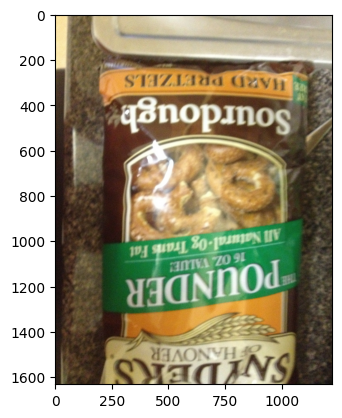

In [68]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
import os
from os import listdir
import matplotlib.pyplot as plt


# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 105
# load the model
model = load_model('model_5.h5')
# load and prepare the photograph
path = os.path.abspath('.') + '/data/val/VizWiz_val_00004698.jpg'
plt.imshow(plt.imread(path))
photo = extract_features(path)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)